## Data Collection

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split

In [2]:
import torch
import torch.nn as nn

import gc

from IPython.display import clear_output, display
from tqdm import tqdm

In [3]:
torch.cuda.is_available()

True

In [4]:
# CHOOSE YOUR DEVICE
# Mac
# DEVICE = 'mps'
# CPU
# DEVICE = 'cpu'
# NVIDIA GPU
DEVICE = 'cuda'

In [5]:
SEED=42

In [6]:
def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    os.environ["PYTHONHASHSEED"] = str(seed)

In [7]:
set_global_seed(SEED)

In [2]:
curves_np = np.load('data/all_curves.npy')
maps_np = np.load('data/all_maps.npy')

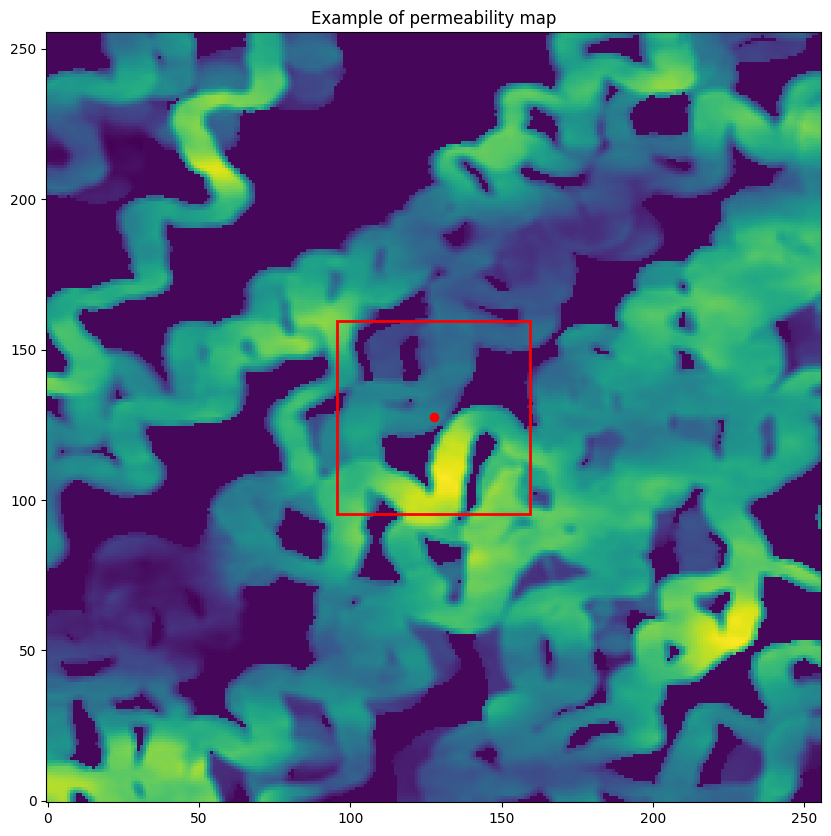

In [9]:
X = np.arange(maps_np.shape[1])
Y = np.arange(maps_np.shape[1])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plt.title('Example of permeability map')
c = ax.pcolormesh(X, Y, maps_np[0])

center_x = X.mean()
center_y = Y.mean()

patch_size = 32

square = patches.Rectangle((center_x - patch_size, center_y - patch_size),
                           2 * patch_size, 2 * patch_size,
                           linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(square)


ax.plot(center_x, center_y, 'ro')

plt.savefig('map.png')
plt.show()


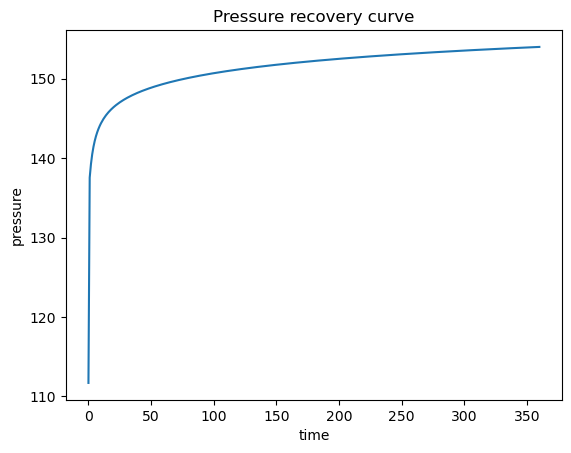

In [3]:
plt.plot(curves_np[0, :])

plt.title('Pressure recovery curve')

plt.xlabel('time')
plt.ylabel('pressure')
plt.savefig('curve.png')
plt.show()

In [11]:
differ_p = curves_np[:, 2:] - curves_np[:, 0:-2]
log_time = np.log(np.arange(start=1, stop=curves_np.shape[1]+1))
diff_p = differ_p / (log_time[2:] - log_time[0:-2])

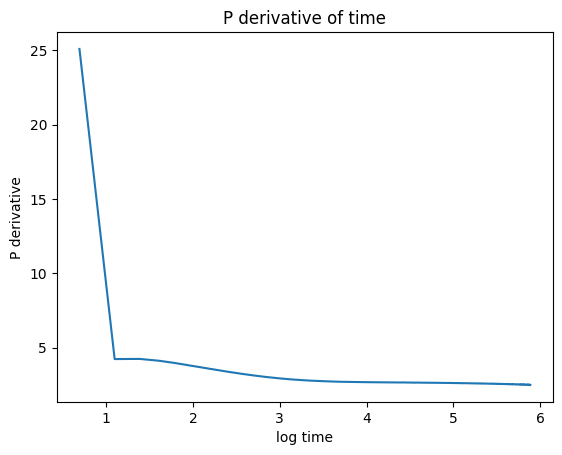

In [12]:
fig, ax = plt.subplots(1, 1)

ax.plot(log_time[1:-1], diff_p[0, :])

plt.title('P derivative of time')
plt.ylabel('P derivative')
plt.xlabel('log time')
plt.show()

In [13]:
# curves_np.shape = (2500, 361)
mean_per_pixel = np.mean(diff_p)
std_per_pixel = np.std(diff_p)

diff_p_norm = (diff_p - mean_per_pixel) / std_per_pixel


In [14]:
# maps_np.shape = (2500, 256, 256)
mean_per_pixel = np.mean(maps_np, axis=0, keepdims=True)  # (1, 256, 256)
std_per_pixel = np.std(maps_np, axis=0, keepdims=True)    # (1, 256, 256)

maps_norm = (maps_np - mean_per_pixel) / std_per_pixel
# try all mean and std
# Minmax scaler

In [15]:
# curves_np.shape = (2500, 361)
mean_per_pixel = np.mean(curves_np)
std_per_pixel = np.std(curves_np)

curves_norm = (curves_np - mean_per_pixel) / std_per_pixel


In [16]:
curves_np.shape

(2500, 361)

In [17]:
maps_norm_tmp, maps_norm_test, curves_norm_tmp, curves_norm_test = train_test_split(maps_norm, curves_norm, test_size=0.1)

In [18]:
maps_norm_test.shape

(250, 256, 256)

In [19]:
maps_norm_train, maps_norm_valid, curves_norm_train, curves_norm_valid = train_test_split(maps_norm_tmp, curves_norm_tmp, test_size=0.1)

In [20]:
maps_norm_train.shape

(2025, 256, 256)

In [21]:
maps_norm_valid.shape

(225, 256, 256)

Here is the function for calculating the volume coefficient B, which is used in formula 3.5.1, and the density \rho, which is used in formula 3.3.1 of pressure. Please note that here you will get 1/x, where x is \rho or B.
They are needed to calculate the regularization for physicality.

In [22]:
def b_rho(p, SI=False, rho=False):
        '''p [bar]'''
        a = 0.0009523809523809535
        b = 0.714285714285714
        if rho: #rho P in bar rho in kg/m3
            # interp_inv_b = a*p + b
            if not SI:
                inv_rho = (a*p + b)*859.507
                # inv_rho.to(self.device)
                return inv_rho
            else:
                inv_rho = (a*p/1e5 + b)*859.507
                # inv_rho.to(self.device)
                return inv_rho
        else:
            if not SI:
                inv_b = a*p + b
                # inv_b.to(self.device)
                return 1/inv_b
            else:
                inv_b =a*p/1e5 + b
                # inv_b.to(self.device)
                return 1/inv_b


## Work with model

In [23]:
class MLP(nn.Module):

    def __init__(self, block_out_channels=list(), seed=45):
        super().__init__()

        self.layers = nn.Sequential()

        for i in range(len(block_out_channels) - 1):
            in_channels = block_out_channels[i]
            out_channels = block_out_channels[i+1]
            self.layers.append(nn.Linear(in_channels, out_channels))
            if i < len(block_out_channels) - 2:
                self.layers.append(nn.BatchNorm1d(out_channels))
                self.layers.append(nn.Tanh())
                # self.layers.append(nn.ReLU())
        
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(
                    layer.weight, 
                    nonlinearity='tanh',
                    # nonlinearity='relu',
                    generator=torch.Generator().manual_seed(seed)
                )
                nn.init.constant_(layer.bias, 0)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.layers(X)
        return X


In [24]:
curves_train = torch.tensor(curves_norm_train, dtype=torch.float)
curves_valid = torch.tensor(curves_norm_valid, dtype=torch.float)
curves_test = torch.tensor(curves_norm_test, dtype=torch.float)

maps_train = torch.tensor(maps_norm_train, dtype=torch.float)
maps_valid = torch.tensor(maps_norm_valid, dtype=torch.float)
maps_test = torch.tensor(maps_norm_test, dtype=torch.float)

curves_train = curves_train.to(DEVICE)
curves_valid = curves_valid.to(DEVICE)
curves_test = curves_test.to(DEVICE)

maps_train = maps_train.to(DEVICE)
maps_valid = maps_valid.to(DEVICE)
maps_test = maps_test.to(DEVICE)

curves_train.requires_grad_(True)
maps_train.requires_grad_(True)


tensor([[[-0.9963, -0.5441,  0.1551,  ...,  1.1007,  1.1977,  1.2480],
         [-1.3500, -0.5357,  0.1291,  ...,  1.0600,  1.1483,  1.1947],
         [-1.3511, -0.3900,  0.1603,  ...,  0.9733,  1.0508,  1.0912],
         ...,
         [-0.9494, -0.9730, -1.0044,  ...,  0.2110,  0.2455,  0.2661],
         [-0.9084, -0.9340, -0.9653,  ...,  0.1493,  0.1823,  0.2031],
         [-0.8791, -0.9000, -0.9273,  ...,  0.1142,  0.1482,  0.1692]],

        [[ 1.2024,  1.1716,  1.1167,  ..., -0.1747, -0.1200, -0.0861],
         [ 0.8280,  0.8647,  0.9429,  ..., -0.0405, -0.0639, -0.0656],
         [ 0.4935,  0.3943,  0.3661,  ...,  0.3700,  0.2891,  0.2511],
         ...,
         [ 1.0496,  1.0479,  1.0435,  ..., -1.3435, -1.3462, -1.3353],
         [ 1.0856,  1.0853,  1.0774,  ..., -1.3540, -1.3558, -1.3378],
         [ 1.1146,  1.1092,  1.0928,  ..., -0.0392, -1.3338, -1.3241]],

        [[-0.1583, -0.1599, -0.1631,  ..., -0.9277, -0.8991, -0.8726],
         [-0.2071, -0.1898, -0.1605,  ..., -0

In [25]:
def get_random_batch_indices(dataset_size, batch_size):
    indices = torch.randperm(dataset_size)[:batch_size]
    return indices

In [26]:
dataset_size = maps_train.shape[0]
batch_size = 10
center = 127
patch_size=32
batch_indices = get_random_batch_indices(dataset_size, batch_size)

In [27]:
mse_loss = nn.MSELoss(reduction='mean')

In [28]:
def calc_q_f(p):
    der_p = (p[:, 2:] - p[:, :-2]) / 2
    

    r = 0.14 / 2
    pi = 3.14
    g = 9.81
    V_u = pi * r ** 2

    inv_B = b_rho(p[:, 1:-1])
    inv_rho = b_rho(p[:, 1:-1], rho=True)
    Cs = 101_325 * V_u / g * inv_rho
    q_f = 24 * Cs * der_p * inv_B

    return q_f


In [29]:
q_f_train = calc_q_f(curves_train)
q_f_mean =  q_f_train.mean()
q_f_std =  q_f_train.std()

In [30]:
def res_loss(curve_sample, curve_nn):
    return mse_loss(curve_nn, curve_sample)

def monotonocity_loss(curve_nn):
    tmp = (curve_nn[:, 1:] - curve_nn[:, 0:-1]).clamp_max(0) # with batch
    # tmp = (curve_nn[1:] - curve_nn[0:-1]).clamp_max(0) # without batch 
    return tmp.square().mean()

def physics_loss(curve_sample, curve_nn):
    q_f_nn = calc_q_f(curve_nn)
    q_f_sample = calc_q_f(curve_sample)
    return mse_loss((q_f_nn - q_f_mean) / q_f_std, (q_f_sample - q_f_mean) / q_f_std)

Here is we can see 2 versions of training wiht physical loss and without it. In the future it may be switched to one function.

In [ ]:
class Trainer:
    def __init__(self, curves_train, curves_valid, curves_test, maps_train, maps_valid, maps_test):
        self.curves_train = curves_train
        self.curves_valid = curves_valid
        self.curves_test = curves_test
        self.maps_train = maps_train
        self.maps_valid = maps_valid
        self.maps_test = maps_test

    def set_params(
            self,
            center = 127,
            patch_size=32,
    ):
        self.center = center
        self.patch_size = patch_size

    def calc_loss(
            self,
            mlp,
            batch,
            curves,
            lambda_mon,
    ):
        
        curve_nn = mlp(batch)
            
        res_loss_calc = res_loss(curves, curve_nn)
        mon_loss = monotonocity_loss(curve_nn)
        loss = res_loss_calc + lambda_mon * mon_loss

        self.res_loss_history.append(res_loss_calc.item())
        self.mon_loss_history.append(lambda_mon * mon_loss.item())
        self.total_loss_history.append(loss.item())
            
        return loss
    
    def calc_loss_physics(
            self,
            mlp,
            batch,
            curves,
            lambda_mon,
            lambda_phy,
    ):
        
        curve_nn = mlp(batch)
            
        res_loss_calc = res_loss(curves, curve_nn)
        mon_loss = monotonocity_loss(curve_nn)
        phy_loss = physics_loss(curves, curve_nn)
        # loss = res_loss_calc + lambda_mon * mon_loss + lambda_phy * phy_loss
        loss = res_loss_calc + lambda_mon * mon_loss

        self.res_loss_history.append(res_loss_calc.item())
        self.mon_loss_history.append(lambda_mon * mon_loss.item())
        self.phy_loss_history.append(lambda_phy * phy_loss.item())
        self.total_loss_history.append(loss.item())
            
        return loss

    def calc_loss_valid(
            self, 
            mlp, 
            lambda_mon
    ):
        

        batch = self.maps_valid[:, 
                self.center-self.patch_size:self.center+self.patch_size, 
                self.center-self.patch_size:self.center+self.patch_size]
        batch = batch.reshape(batch.size(0), -1)

        loss_av = 0
        with torch.no_grad():  
            loss = self.calc_loss(mlp, batch, self.curves_valid, lambda_mon)
            loss_av += loss.item()

        if loss_av < self.best_loss:
            self.best_loss = loss_av
            self.best_state_dict = mlp.state_dict()
            self.patience_counter = 0
        else:
            self.patience_counter = self.patience_counter + 1


    def calc_loss_valid_phy(
            self, 
            mlp, 
            lambda_mon,
            lambda_phy
    ):
        

        batch = self.maps_valid[:, 
                self.center-self.patch_size:self.center+self.patch_size, 
                self.center-self.patch_size:self.center+self.patch_size]
        batch = batch.reshape(batch.size(0), -1)

        loss_av = 0
        with torch.no_grad():  
            loss = self.calc_loss_physics(mlp, batch, self.curves_valid, lambda_mon, lambda_phy)
            loss_av += loss.item()

        if loss_av < self.best_loss:
            self.best_loss = loss_av
            self.best_state_dict = mlp.state_dict()
            self.patience_counter = 0
        else:
            self.patience_counter = self.patience_counter + 1


    def train(self, 
            mlp,
            n_epochs=1000,
            learning_rate=1.0e-3,
            n_patience=100,
            batch_size=5,
            lambda_mon = 1
        ):
        set_global_seed(SEED)

        optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20)

        self.res_loss_history = list()
        self.total_loss_history = list()
        self.mon_loss_history = list()

        fig, ax = plt.subplots(1, 1)

        self.best_loss = np.inf
        self.best_state_dict = None
        self.patience_counter = 0

        self.batch_size = batch_size

        self.dataset_size = self.maps_train.shape[0]
        
        mlp.train()
        for i in tqdm(range(n_epochs)):
            batch_indices = get_random_batch_indices(self.dataset_size, self.batch_size)
            batch = self.maps_train[batch_indices, 
                self.center-self.patch_size:self.center+self.patch_size, 
                self.center-self.patch_size:self.center+self.patch_size]
            batch = batch.reshape(batch.size(0), -1)

            loss = self.calc_loss(mlp, batch, self.curves_train[batch_indices, :], lambda_mon)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

            self.calc_loss_valid(mlp, lambda_mon)
            
            if i % 50 == 0:
                ax.clear()
                ax.set_title(f'num epochs with no improvement: {self.patience_counter} / {n_patience}')
                ax.plot(self.res_loss_history, label='RES loss', alpha=0.8, color='m')
                ax.plot(self.mon_loss_history, label='MON loss', alpha=0.8, color='b')
                ax.plot(self.total_loss_history, label='Total loss', alpha=0.8)
                ax.legend()
                ax.set_yscale('log')
                clear_output(wait=True)
                display(fig)

                plt.close()
                
            if self.patience_counter == n_patience:
                print(f'No improvement in {n_patience} epochs, early stopping ..')
                break

        mlp.load_state_dict(self.best_state_dict)

        ax.clear()
        ax.set_title(f'num epochs with no improvement: {self.patience_counter} / {n_patience}')
        ax.plot(self.res_loss_history, label='RES loss', alpha=0.8, color='m')
        ax.plot(self.mon_loss_history, label='MON loss', alpha=0.8, color='b')
        ax.plot(self.total_loss_history, label='Total loss', alpha=0.8)
        ax.legend()
        ax.set_yscale('log')
        clear_output(wait=True)
        display(fig)
        

        return mlp
    
    def train_physics(self, 
            mlp,
            n_epochs=1000,
            learning_rate=1.0e-3,
            n_patience=100,
            batch_size=5,
            lambda_mon = 1,
            lambda_phy=1
        ):
        set_global_seed(SEED)

        optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20)

        self.res_loss_history = list()
        self.total_loss_history = list()
        self.mon_loss_history = list()
        self.phy_loss_history = list()

        fig, ax = plt.subplots(1, 1)

        self.best_loss = np.inf
        self.best_state_dict = None
        self.patience_counter = 0

        self.batch_size = batch_size

        self.dataset_size = self.maps_train.shape[0]
        
        mlp.train()
        for i in tqdm(range(n_epochs)):
            batch_indices = get_random_batch_indices(self.dataset_size, self.batch_size)
            batch = self.maps_train[batch_indices, 
                self.center-self.patch_size:self.center+self.patch_size, 
                self.center-self.patch_size:self.center+self.patch_size]
            batch = batch.reshape(batch.size(0), -1)

            loss = self.calc_loss_physics(mlp, batch, self.curves_train[batch_indices, :], lambda_mon, lambda_phy)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

            self.calc_loss_valid_phy(mlp, lambda_mon, lambda_phy)
            
            if i % 50 == 0:
                ax.clear()
                ax.set_title(f'num epochs with no improvement: {self.patience_counter} / {n_patience}')
                ax.plot(self.res_loss_history, label='RES loss', alpha=0.8, color='m')
                ax.plot(self.mon_loss_history, label='MON loss', alpha=0.8, color='b')
                ax.plot(self.phy_loss_history, label='PHY loss', alpha=0.8)
                ax.plot(self.total_loss_history, label='Total loss', alpha=0.8)
                ax.legend()
                ax.set_yscale('log')
                clear_output(wait=True)
                display(fig)

                plt.close()
                
            if self.patience_counter == n_patience:
                print(f'No improvement in {n_patience} epochs, early stopping ..')
                break

        mlp.load_state_dict(self.best_state_dict)

        ax.clear()
        ax.set_title(f'num epochs with no improvement: {self.patience_counter} / {n_patience}')
        ax.plot(self.res_loss_history, label='RES loss', alpha=0.8, color='m')
        ax.plot(self.mon_loss_history, label='MON loss', alpha=0.8, color='b')
        ax.plot(self.phy_loss_history, label='PHY loss', alpha=0.8)
        ax.plot(self.total_loss_history, label='Total loss', alpha=0.8)
        ax.legend()
        ax.set_yscale('log')
        clear_output(wait=True)
        display(fig)
        

        return mlp
    


## Training part

In [ ]:
mlp = MLP(block_out_channels=[(2 * patch_size) ** 2, 64, 64, curves_train.shape[1]])
mlp = mlp.to(DEVICE)
mlp

MLP(
  (layers): Sequential(
    (0): Linear(in_features=4096, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=361, bias=True)
  )
)

In [33]:
trainer = Trainer(curves_train, curves_valid, curves_test, maps_train, maps_valid, maps_test)
trainer.set_params(center, patch_size)

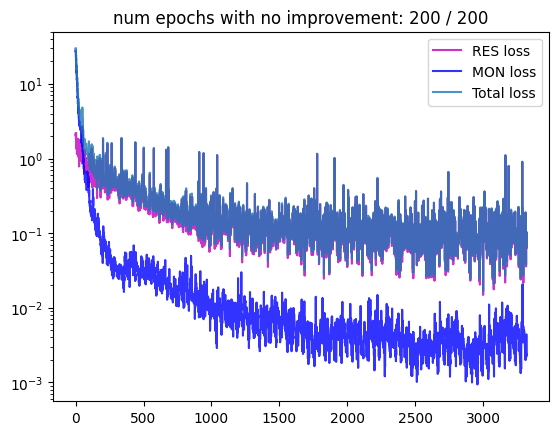

In [34]:
mlp = trainer.train(
    mlp, 
    n_epochs=3000,
    n_patience=200,
    learning_rate=5e-3,
    # batch_size=1,
    batch_size=20,
    # lambda_mon = 1e6
    lambda_mon = 25
)

In [35]:
mlp.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=4096, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=361, bias=True)
  )
)

In [36]:
def rmse(real, pred):
    return torch.sqrt(torch.mean(torch.square(real - pred)))

In [37]:
def r2(real, pred):
    mse = torch.mean(torch.square(real - pred))
    var = torch.var(real, correction=0)
    return (1.0 - mse / var).item()

In [38]:
r2_scores = torch.zeros(maps_test.shape[0])
rmse_scores = torch.zeros(maps_test.shape[0])
# r2_scores = torch.zeros_like(maps)
for i in range(maps_test.shape[0]):
    prediction = mlp(maps_test[i, center-patch_size:center+patch_size, center-patch_size:center+patch_size].reshape(1, -1))
    r2_scores[i] = r2(curves_test[i, :].detach().cpu(), prediction.reshape(-1).detach().cpu())
    rmse_scores[i] = rmse(curves_test[i, :].detach().cpu(), prediction.reshape(-1).detach().cpu())

print(f"r2_mean = {r2_scores.mean():.3f}, rmse_mean = {rmse_scores.mean():.3f}")

r2_mean = 0.788, rmse_mean = 0.191


In [39]:
trainer = Trainer(curves_train, curves_valid, curves_test, maps_train, maps_valid, maps_test)
trainer.set_params(center, patch_size)

mlp_phy = MLP(block_out_channels=[(2 * patch_size) ** 2, 64, 64, curves_train.shape[1]])
mlp_phy = mlp_phy.to(DEVICE)
mlp_phy

MLP(
  (layers): Sequential(
    (0): Linear(in_features=4096, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=361, bias=True)
  )
)

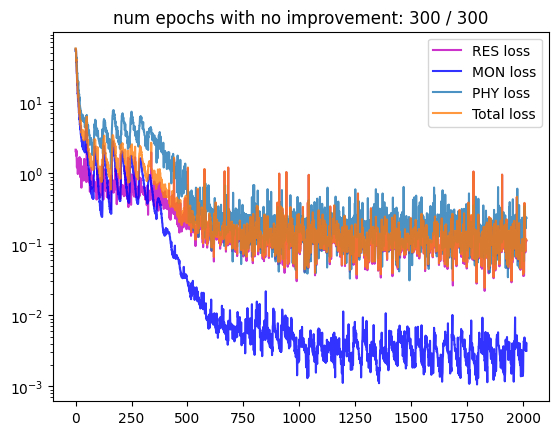

In [40]:
mlp_phy = trainer.train_physics(
    mlp_phy, 
    n_epochs=3000,
    n_patience=300,
    learning_rate=1e-2,
    # batch_size=1,
    batch_size=20,
    # lambda_mon = 1e6
    lambda_mon = 50,
    lambda_phy=2
)

In [41]:
# gc.collect()
# torch.cuda.empty_cache()

In [42]:
mlp_phy.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=4096, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=361, bias=True)
  )
)

In [43]:
r2_scores_phy = torch.zeros(maps_test.shape[0])
rmse_scores_phy = torch.zeros(maps_test.shape[0])
# r2_scores = torch.zeros_like(maps)
for i in range(maps_test.shape[0]):
    prediction = mlp_phy(maps_test[i, center-patch_size:center+patch_size, center-patch_size:center+patch_size].reshape(1, -1))
    r2_scores_phy[i] = r2(curves_test[i, :].detach().cpu(), prediction.reshape(-1).detach().cpu())
    rmse_scores_phy[i] = rmse(curves_test[i, :].detach().cpu(), prediction.reshape(-1).detach().cpu())

print(f"r2_mean = {r2_scores_phy.mean():.3f}, rmse_mean = {rmse_scores_phy.mean():.3f}")

r2_mean = 0.681, rmse_mean = 0.238


In [44]:
t = np.arange(curves_test.shape[1])

In [45]:
def plot_ic(real, pred):
    fig, ax = plt.subplots(1, 1)

    ax.set_title(f'Initial condition, score = {r2(real, pred):.2f}')
    ax.plot(t, pred, label='prediction')
    ax.plot(t, real, label='ground truth')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('normalized pressure')

    plt.savefig('predict.png')

def plot_ic2(real, pred1, pred2):
    fig, ax = plt.subplots(1, 1)

    ax.set_title(f'PRC, score1 = {r2(real, pred1):.2f}, score2 = {r2(real, pred2):.2f}')
    ax.plot(t, pred1, label='NN')
    ax.plot(t, pred2, label='PINN')
    ax.plot(t, real, label='ground truth')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('normalized pressure')

    plt.savefig('predict2.png')

In [49]:
idx = 0
prediction1 = mlp(maps_test[idx, center-patch_size:center+patch_size, center-patch_size:center+patch_size].reshape(1, -1))
prediction2 = mlp_phy(maps_test[idx, center-patch_size:center+patch_size, center-patch_size:center+patch_size].reshape(1, -1))

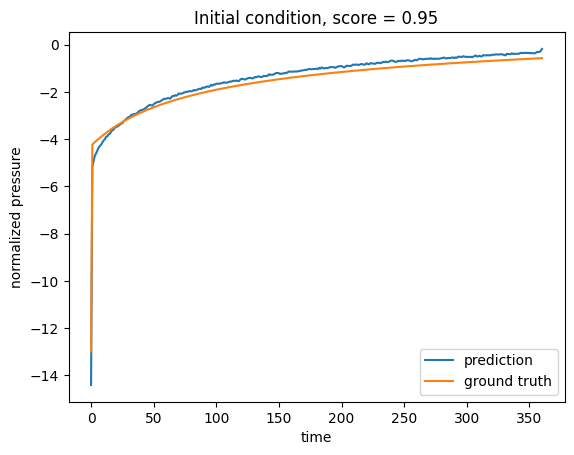

In [47]:
plot_ic(
    real=curves_test[idx, :].detach().cpu(),
    pred=prediction1.reshape(-1).detach().cpu()
)

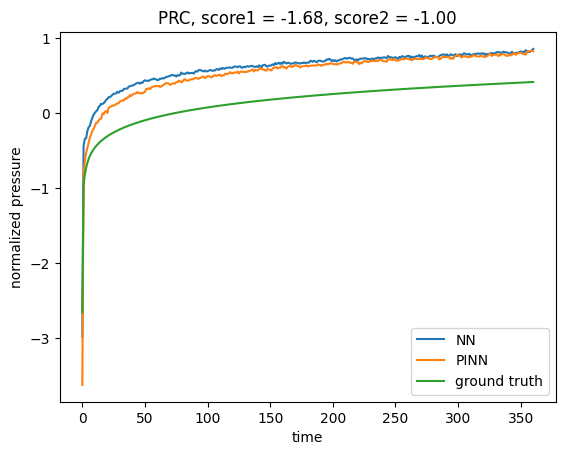

In [50]:
plot_ic2(
    real=curves_test[idx, :].detach().cpu(),
    pred1=prediction1.reshape(-1).detach().cpu(),
    pred2=prediction2.reshape(-1).detach().cpu()
)